In [200]:
import sys
import numpy as np
import scipy as sc
import scipy.linalg as la
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (8,10)
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objects as go
from scipy.optimize import minimize_scalar, minimize, shgo, basinhopping, differential_evolution, dual_annealing
#from scipy.misc import derivative
from matplotlib import cm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import FloatProgress
from IPython.display import display, HTML, clear_output
from IPython.display import Image, SVG
#import time
%matplotlib notebook
%load_ext tikzmagic
#https://github.com/mkrphys/ipython-tikzmagic
#
#https://github.com/mkrphys/ipython-tikzmagic/issues/18
#On Ubuntu 18.04, I ran into the same issue. It seems the problem was because ImageMagick tightened 
#their security policy so that it prevented the generation of PNG file from the PDF file generated by latex. 
#To fix this problem, I edited /etc/ImageMagick-6/policy.xml, changing the following
#
#<policy domain="coder" rights="none" pattern="PDF />
#
#to
#
#<policy domain="coder" rights="read|write" pattern="PDF />
#
#http://blog.invibe.net/posts/2015-01-20-using-tikzmagic.html
#https://stackoverflow.com/questions/45671481/how-do-i-center-the-outputs-on-a-python-jupyter-notebook
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
#print(sc.__version__)
#print(numpy.__version__)

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


# Hubbard Model with Spin Spiral State on the Square Lattice

## Goal

## Lattice and Unit Cell
1-Site Unit Cell

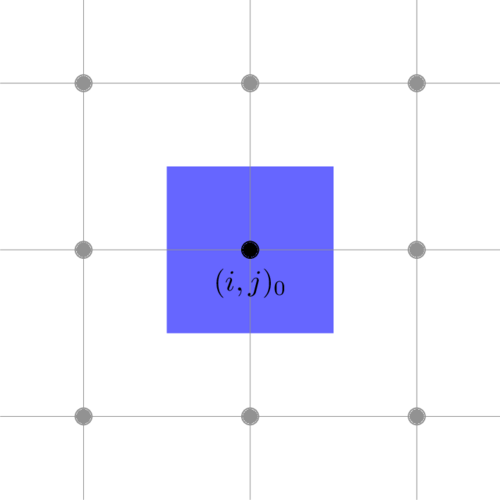

In [50]:
%%tikz -f png -s 800,500 -sc 1.0
%\tikzset{>=stealth,font=\Large};

\fill [opacity=0.75,blue!80] (+1,+1) -- (+3,+1) -- (+3,+3) -- (+1,+3) -- cycle;

\draw [style=help lines, step=2] (-1,-1) grid (+5,+5);
 
\filldraw [color=gray]	(0,0) circle (.1);
\filldraw [color=gray]	(0,2) circle (.1);
\filldraw [color=gray]	(0,4) circle (.1);

\filldraw [color=gray]	(2,0) circle (.1);
\filldraw [color=black]	(2,2) circle (.1);
\filldraw [color=gray]	(2,4) circle (.1);

\filldraw [color=gray]	(4,0) circle (.1);
\filldraw [color=gray]	(4,2) circle (.1);
\filldraw [color=gray]	(4,4) circle (.1);

\draw ( 2, 1.9) node[anchor=north] {$(i,j)_{0}$};

## Model
$$\newcommand{\OP}[1]{\hat{#1}}$$
$$\newcommand{\vectr}[1]{\boldsymbol{#1}}$$

The Hubbard model Hamiltonian for a n-site unit cell with site index $\alpha$ reads:

\begin{equation}
\OP{H} = \underbrace{\sum_{i,j}\sum_{\alpha,\beta}\sum_{\sigma} t^{\phantom{\dagger}}_{(i,\alpha),(j,\beta)} \hat{c}^{\dagger}_{i,\alpha,\sigma} \hat{c}^{\phantom{\dagger}}_{j,\beta,\sigma}}_{=: \OP{H}_0}
 + \underbrace{U \sum_{i,\alpha}\hat{n}^{\phantom{\dagger}}_{i,\alpha,\uparrow}\hat{n}^{\phantom{\dagger}}_{i,\alpha,\downarrow}}_{=: \OP{H}_\mathrm{I}}
\end{equation}

with $\hat{n}^{\phantom{\dagger}}_{i,\alpha,\sigma} =  \hat{c}^{\dagger}_{i,\alpha,\sigma} \hat{c}^{\phantom{\dagger}}_{i,\alpha,\sigma}$. The integer index set $\{i,j\}$ labels the respective cells originating from shifting the unit cell (UC) by integral multiples of the translation vectors and $\{\alpha,\alpha'\}$ the respective site index within the cell. The number of cells will be labeled $N_{\mathrm{UC}}$ and the number of basis sites $N_{\mathrm{B}}$.

### Hopping


The Fourier transformation of the general hoping term $\OP{H}_0$ reads:

\begin{equation}
 \OP{H}_0 = \sum_{\vectr{k}}\sum_{\alpha,\beta}\sum_{\sigma} \hat{c}^{\dagger}_{\vectr{k},\alpha,\sigma} \hat{c}^{\phantom{\dagger}}_{\vectr{k},\beta,\sigma} \underbrace{\left( \sum_{\vectr{\eta}_j} t^{\phantom{\dagger}}_{\alpha,\beta} e^{i\vectr{k}\cdot\vectr{\eta}_j} \right)}_{=: t_{\alpha,\beta}(\vectr{k})}.
\end{equation}

with

\begin{equation}
t_{\alpha,\beta}(\vectr{k}) = \sum_{\vectr{\eta}_j} t^{\alpha,\beta}_{\vectr{\eta}_j} e^{i\vectr{k}\cdot\vectr{\eta}_j}
\end{equation}

In [51]:
def Hopping_UC_1S(k):
        t = -1.0
        Translations = np.array([[1.0,0.0],[-1.0,0.0],[0.0,1.0],[0.0,-1.0]])
        hopping_amplitude = 0.0+0.0j
        for Tvec in Translations:
            hopping_amplitude += t*np.exp((Tvec[0]*k[0]+Tvec[1]*k[1])*1.0j)
        return hopping_amplitude

### The Trial Hamiltonian

\begin{equation}
\begin{split}
\OP{H}^{\mathrm{HF}} 
= \sum_{\vectr{k}}\sum_{\alpha,\alpha'}
&\left(\hat{c}^{\dagger}_{\vectr{k},\alpha,\uparrow} 
\mathcal{H}^{\uparrow\uparrow}_{\alpha,\alpha'} \left(\vectr{k}\right)\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k},\alpha',\uparrow}
%
+\hat{c}^{\dagger}_{\vectr{k},\alpha,\uparrow} 
\mathcal{H}^{\uparrow\downarrow}_{\alpha,\alpha'}\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k} + \vectr{q},\alpha',\downarrow}\right.\\
%
+&\left.\hat{c}^{\dagger}_{\vectr{k}+\vectr{q},\alpha,\downarrow} 
\mathcal{H}^{\downarrow\uparrow}_{\alpha,\alpha'}\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k},\alpha',\uparrow}
%
+\hat{c}^{\dagger}_{\vectr{k}+\vectr{q},\alpha,\downarrow}
\mathcal{H}^{\downarrow\downarrow}_{\alpha,\alpha'} \left(\vectr{k}+\vectr{q}\right)\, 
\hat{c}^{\phantom{\dagger}}_{\vectr{k} + \vectr{q},\alpha',\downarrow}\right)
%
\end{split}
\end{equation}

with the matrix elements for spin and charge decoupling read:

\begin{align}
\mathcal{H}^{\uparrow\uparrow}_{\alpha,\alpha'} \left(\vectr{k}\right) &= 
t_{\alpha,\alpha'}\left(\vectr{k}\right)
+ \delta_{\alpha,\alpha'}\left[\frac{U}{2}\left( \varrho^{\phantom{\dagger}}_{\alpha} - m_{\alpha} \cos{(\theta_{\alpha})} \right) \right]\\
%
\mathcal{H}^{\uparrow\downarrow}_{\alpha,\alpha'} = \mathcal{H}^{\downarrow\uparrow}_{\alpha,\alpha'} &=
\delta_{\alpha,\alpha'} \left[ -\frac{U m_{\alpha}}{2}\sin{(\theta_{\alpha})}\right]\\
%
\mathcal{H}^{\downarrow\downarrow}_{\alpha,\alpha'} \left(\vectr{k}+\vectr{q}\right) &= 
t_{\alpha,\alpha'}\left(\vectr{k}+\vectr{q}\right)
+ \delta_{\alpha,\alpha'}\left[\frac{U}{2}\left( \varrho^{\phantom{\dagger}}_{\alpha} + m_{\alpha} \cos{(\theta_{\alpha})} \right) \right]
\end{align}

Indexing Matrix elements

\begin{equation}
 a = 2(\alpha - 1) + \sigma
\end{equation}

with spin index $\sigma\in\{0 (\uparrow),1 (\downarrow)\}$ and site index $\alpha\in\{1,2,\dots,N_B\}$

In [52]:
def Hamiltonian_UC_1S(k,q,n,m,theta):
    """"Returns np.array like Matrix"""
    
    A = np.zeros((2, 2), dtype=complex)
    
    A[0][0] = Hopping_UC_1S(k)
    A[0][0] += 0.5*Hubbard_U*n-0.5*Hubbard_U*m*np.cos(theta) + 0j
        
    A[0][1] = -0.5*Hubbard_U*m*np.sin(theta) + 0j
    
    A[1][0] = -0.5*Hubbard_U*m*np.sin(theta) + 0j
    
    A[1][1] = Hopping_UC_1S(k+q)
    A[1][1] += 0.5*Hubbard_U*n+0.5*Hubbard_U*m*np.cos(theta) + 0j
    
    return A

In [53]:
Hubbard_U = 0.0

Hamiltonian_UC_1S(np.array([0.0,0.0]),np.array([0.0,0.0]),0.0,0.0,0.0)

array([[-4.+0.j,  0.+0.j],
       [ 0.+0.j, -4.+0.j]])

In [223]:
number_of_steps = 50
kx_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)
ky_grid = np.linspace(-np.pi, np.pi, number_of_steps, endpoint=True)

In [178]:
def Set_Spectrum_Bands_UC_1S(q,n,m,theta):
    global kx_grid
    global ky_grid
    
    Band_1 = np.zeros((1,number_of_steps))
    tempBand_1 = np.zeros(number_of_steps)

    Band_2 = np.zeros((1,number_of_steps))
    tempBand_2 = np.zeros(number_of_steps)
     
    for ky in ky_grid:
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S(np.array([kx,ky]),q,n,m,theta))
            tempBand_1[idx] = w[0]
            tempBand_2[idx] = w[1]
        Band_1 = np.concatenate((Band_1,[tempBand_1]), axis=0)
        Band_2 = np.concatenate((Band_2,[tempBand_2]), axis=0)
    
    Band_1 = np.delete(Band_1, 0, 0)
    Band_2 = np.delete(Band_2, 0, 0)
    return Band_1, Band_2

def Set_Spectrum_Bands_UC_1S_evecs(q,n,m,theta):
    global kx_grid
    global ky_grid
    
    Band_1 = np.zeros((1,number_of_steps))
    tempBand_1 = np.zeros(number_of_steps)

    Band_2 = np.zeros((1,number_of_steps))
    tempBand_2 = np.zeros(number_of_steps)
    
    Band_1_evecs = np.zeros((1,number_of_steps,2),dtype=np.complex)
    tempBand_1_evecs = np.zeros((1,2),dtype=np.complex)
    
    Band_2_evecs = np.zeros((1,number_of_steps,2),dtype=np.complex)
    tempBand_2_evecs = np.zeros((1,2),dtype=np.complex)
    
    for ky in ky_grid:
        tempBand_1_evecs = np.zeros((1,2),dtype=np.complex)
        tempBand_2_evecs = np.zeros((1,2),dtype=np.complex)
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S(np.array([kx,ky]),q,n,m,theta))
            tempBand_1[idx] = w[0]
            tempBand_2[idx] = w[1]
            tempBand_1_evecs = np.concatenate((tempBand_1_evecs,[v[0]]), axis=0)
            tempBand_2_evecs = np.concatenate((tempBand_2_evecs,[v[1]]), axis=0)
        Band_1 = np.concatenate((Band_1,[tempBand_1]), axis=0)
        Band_2 = np.concatenate((Band_2,[tempBand_2]), axis=0)
        
        tempBand_1_evecs = np.delete(tempBand_1_evecs, 0, 0)        
        tempBand_2_evecs = np.delete(tempBand_2_evecs, 0, 0)
        Band_1_evecs = np.concatenate((Band_1_evecs,[tempBand_1_evecs]), axis=0)
        Band_2_evecs = np.concatenate((Band_2_evecs,[tempBand_2_evecs]), axis=0)
            
    Band_1 = np.delete(Band_1, 0, 0)
    Band_2 = np.delete(Band_2, 0, 0)
    Band_1_evecs = np.delete(Band_1_evecs, 0, 0)
    Band_2_evecs = np.delete(Band_2_evecs, 0, 0)
    return Band_1, Band_1_evecs, Band_2, Band_2_evecs

def get_Bands_UC_1S(k,q,n,m,theta):
    w, v = la.eigh(Hamiltonian_UC_1S(k,q,n,m,theta))
    return w

def Set_Spectrum_Band_i_UC_1S(i,q,n,m,theta):
    Band = np.zeros((1,number_of_steps))
    tempBand = np.zeros(number_of_steps)
    
    for ky in ky_grid:
        for idx, kx in enumerate(kx_grid):
            w, v = la.eigh(Hamiltonian_UC_1S(np.array([kx,ky]),q,n,m,theta))
            tempBand[idx] = w[i]
        Band = np.concatenate((Band,[tempBand]), axis=0)
    
    Band = np.delete(Band, 0, 0)

    return Band_1

In [122]:
Band_1, Band_1_evec, Band_2, Band_2_evec = Set_Spectrum_Bands_UC_1S_evecs(np.array([0.0,0.0]),0.0,0.0,0.0)

In [123]:
print(Band_1_evec)

[[[-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  ...
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]]

 [[-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  ...
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]]

 [[-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  ...
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]]

 ...

 [[-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  ...
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]]

 [[-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  ...
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]]

 [[-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  ...
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]
  [-1.+0.j -0.+0.j]]]


In [65]:
test = np.zeros((1,3,2), dtype=np.complex)
print(test)
addt = np.array([[1.0+2.0j, 1.5+3.0j],[1.0+2.0j, 1.5+3.0j],[1.0+2.0j, 1.5+3.0j]])
test2 = np.concatenate((test,[addt]), axis=0)
#test2 = np.delete(test2, 0, 0)
print(test2)

[[[0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]]
[[[0. +0.j 0. +0.j]
  [0. +0.j 0. +0.j]
  [0. +0.j 0. +0.j]]

 [[1. +2.j 1.5+3.j]
  [1. +2.j 1.5+3.j]
  [1. +2.j 1.5+3.j]]]


In [10]:
Band_1, Band_2 = Set_Spectrum_Bands_UC_1S(np.array([0.0,0.0]),0.0,0.0,0.0)

In [66]:
path_1_kx = np.linspace(0.0, np.pi, number_of_steps, endpoint=True)
path_3_kx = np.linspace(np.pi, 0.0, number_of_steps, endpoint=True)
path_1 = np.ndarray((number_of_steps,2), dtype=float)
path_2 = np.ndarray((number_of_steps,2), dtype=float)
path_3 = np.ndarray((number_of_steps,2), dtype=float)

for ikx, kx in enumerate(path_1_kx):
    path_1[ikx][0] = kx
    path_1[ikx][1] = 0.0

for iky, ky in enumerate(path_1_kx):
    path_2[iky][0] = np.pi
    path_2[iky][1] = ky

for ikx, kx in enumerate(path_3_kx):
    path_3[ikx][0] = kx
    path_3[ikx][1] = kx

In [67]:
# bandstructure along paths 1, 2, and 3

bandstructure_path_1 = np.ndarray((number_of_steps,2), dtype=float)
bandstructure_path_2 = np.ndarray((number_of_steps,2), dtype=float)
bandstructure_path_3 = np.ndarray((number_of_steps,2), dtype=float)

q = np.zeros(2, dtype=float)
n = 0.0
m = 0.0
theta = 0.0

for idk,k in enumerate(path_1):
    bandstructure_path_1[idk] = get_Bands_UC_1S(k,q,n,m,theta)

for idk,k in enumerate(path_2):
    bandstructure_path_2[idk] = get_Bands_UC_1S(k,q,n,m,theta)

for idk,k in enumerate(path_3):
    bandstructure_path_3[idk] = get_Bands_UC_1S(k,q,n,m,theta)

<IPython.core.display.Javascript object>


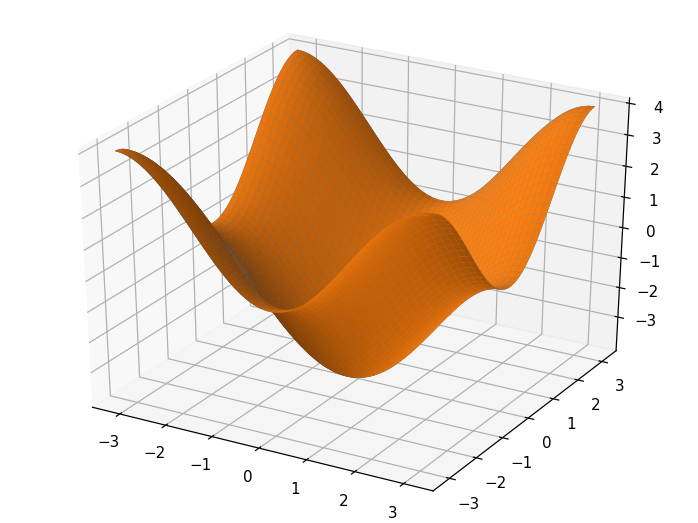

In [114]:
fig_bandstructure = plt.figure()
ax1 = Axes3D(fig_bandstructure)
kx, ky = np.meshgrid(kx_grid, ky_grid)
surf = ax1.plot_surface(kx, ky, Band_1, rstride=1, cstride=1)
surf = ax1.plot_surface(kx, ky, Band_2, rstride=1, cstride=1)
plt.show()

In [ ]:
fig = go.Figure(data=[go.Surface(x=kx_grid, y=ky_grid, z=Band_1,colorscale='RdBu',opacity=0.5),
                      go.Surface(x=kx_grid, y=ky_grid, z=Band_2,colorscale='RdBu',opacity=0.5)])

fig.update_traces(cmax=4,cmin=-4)

fig.update_layout(#title='bandstructure', 
                  autosize=True,
                  #width=800, 
                  #height=500,
                  margin=dict(l=20, r=20, b=20, t=20)
                 )

fig.show()

In [ ]:
colors_Band_1 = np.zeros(shape=Band_1.shape)    
colors_Band_2 = np.ones(shape=Band_2.shape)

colorscale = [[0, 'red'], 
              [1, 'blue']]

fig = go.Figure(data=[go.Surface(x=kx_grid, 
                                 y=ky_grid,
                                 z=Band_1,
                                 surfacecolor=colors_Band_1,
                                 opacity=.7,
                                 #name="Trace A",
                                 cmin=0,
                                 cmax=1,
                                 showscale=False,
                                 colorscale=colorscale),
                      go.Surface(x=kx_grid, 
                                 y=ky_grid, 
                                 z=Band_2,
                                 surfacecolor=colors_Band_2, 
                                 opacity=.7, 
                                 #name="Trace B", 
                                 cmin=0,
                                 cmax=1,
                                 showscale=False,
                                 colorscale=colorscale)])

fig.update_layout(#title='bandstructure', 
                  autosize=True,
                  #width=800, 
                  #height=500,
                  margin=dict(l=20, r=20, b=20, t=20))

fig.show()

In [ ]:
# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, 2*np.pi, 0.5):
    Band_1, Band_2 = Set_Spectrum_Bands_UC_1S(np.array([step,step]),0.0,0.0,0.0)
    fig.add_trace(
        go.Surface( x=kx_grid, 
                    y=ky_grid,
                    z=Band_1,
                    surfacecolor=colors_Band_1,
                    opacity=.7,
                    #name="Trace A",
                    cmin=0,
                    cmax=1,
                    showscale=False,
                    colorscale=colorscale,
                    visible=False))
    fig.add_trace(
         go.Surface( x=kx_grid, 
                    y=ky_grid,
                    z=Band_2,
                    surfacecolor=colors_Band_2,
                    opacity=.7,
                    #name="Trace A",
                    cmin=0,
                    cmax=1,
                    showscale=False,
                    colorscale=colorscale,
                    visible=False))
    
# Make 0th trace visible
fig.data[0].visible = True
fig.data[1].visible = True

# Create and add slider
steps = []
for i in range(int(0.5*len(fig.data))):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(fig.data)],
    )
    step["args"][1][2*i] = True  # Toggle i'th trace to "visible"
    step["args"][1][2*i+1] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 10},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

### Cut through 1. Brillouin Zone - Bandstructure

In [ ]:
%%tikz -f png -s 800,500 -sc 1.0
\tikzset{>=stealth,font=\Large};

\filldraw[fill=green!20!white, draw=black, dotted] (-pi,pi) rectangle (pi,-pi);

\draw[very thin, gray, step=.25*pi] (-1.0*pi,1.0*pi) grid (1.0*pi,-1.0*pi);
\draw[color=black, thick, solid,->] (-1.5*pi,0.0) -- (1.5*pi,0.0);
\draw[color=black, thick, solid,->] (0.0,-1.5*pi) -- (0.0,1.5*pi);

\draw[anchor=north east] (0.0,0.0) node {$\Gamma$};
\draw[anchor=north] (pi,0.0) node {$X$};
\draw[anchor=south west] (pi,pi) node {$M$};

\draw[color=blue, very thick, solid] (-1.0*pi,0.0) -- (1.0*pi,0.0);
\draw[color=blue, very thick, solid] (1.0*pi,0.0) -- (1.0*pi,pi);
\draw[color=blue, very thick, solid] (1.0*pi,pi) -- (0.0,0.0);

%\draw[anchor=north] (1.0,0.0) node {$\frac{1}{2}$};
%\draw[anchor=north] (0.0,0.0) node {$0$};
%\draw[anchor=east] (0.0,3.5) node {$2$};


In [ ]:
# Create Figure and Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4), sharey=True, dpi=120)
fig.subplots_adjust(wspace=0)


# Plot
ax1.plot(bandstructure_path_1, 'go')  # greendots
ax2.plot(bandstructure_path_2, 'b*')  # bluestart
ax3.plot(bandstructure_path_3, 'r*')  # bluestart

# Title, X and Y labels, X and Y Lim
#ax1.set_title('Scatterplot Greendots')
#ax2.set_title('Scatterplot Bluestars')
ax1.set_ylabel('E')
ax1.set_xlabel('$k_x$')
ax1.set_xlim(0,number_of_steps)
ax1.set_xticks([0.0,number_of_steps])
ax1.set_xticklabels(['$\Gamma$','$X$'])

ax2.set_xlabel('$k_y$')
ax2.set_xlim(0,number_of_steps)
ax2.set_xticks([number_of_steps])
ax2.set_xticklabels(['$M$'])

ax3.set_xlabel('$(k_x,k_y)$')
ax3.set_xlim(0,number_of_steps)
ax3.set_xticks([number_of_steps])
ax3.set_xticklabels(['$\Gamma$'])

plt.show()

In [ ]:
#from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

fig_bandstructure = plt.figure()
kx, ky = np.meshgrid(kx_grid, ky_grid)
im = plt.imshow(Band_1, extent=(-np.pi,np.pi,-np.pi,np.pi), cmap=cm.RdBu) # drawing the function
plt.xticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.yticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
# adding the Contour lines with labels
cset = plt.contour(kx, ky, Band_1,np.arange(-4,4.0,1.0),linewidths=2,cmap=cm.Set2)
plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plt.colorbar(im) # adding the colobar on the right
#plt.xticks([1,2])
# latex fashion title
plt.show()

In [ ]:
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
#import matplotlib.pyplot as plt

kx, ky = np.meshgrid(kx_grid, ky_grid)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(kx, ky, Band_2, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# The Grand Canonical Functional

$\newcommand{\cOP}[1]{{\hat{#1}^{\dagger}}}$
$\newcommand{\aOP}[1]{{\hat{#1}^{\phantom{\dagger}}}}$

$\newcommand{\EW}[1]{\left<{#1}\right>}$
$\DeclareMathOperator{\Tr}{Tr}$

\begin{equation*}
\Phi\left[\OP{\rho}_{\mathrm{eff}}\right] =
\EW{\OP{H}}_{\mathrm{eff}} - \EW{\OP{H}_{\mathrm{eff}}}_{\mathrm{eff}} + \Phi_{\mathrm{eff}} 
\geq \Phi\left[ \OP{\rho}_{\mathrm{GK}} \right] = \Omega(T,\mu)
\end{equation*}

with the standard grand potential for the effective density operator:

\begin{equation*}
 \Phi_{\mathrm{eff}} = -k_BT \ln{\left(Z_{\mathrm{eff}}\right)} = -k_BT \ln{\left(\Tr\left\{e^{-\beta\left(\OP{H}_{\mathrm{eff}}-\mu\OP{N}\right)} \right\}\right)}.
\end{equation*}

We choose a proper trial hamiltonian, which is the Hartree Fock decoupled one of the previous section here. This induces the parametrization of the effective statistical operator as a consequence and thus, results in the scalar field $\Phi\left(\{ \varrho_\alpha, \mathbf{m}_{\alpha} \}; \OP{\rho}_{\mathrm{eff}} \right)$ depending on the chosen set of parameters:

\begin{equation*}
 \Phi\left[\OP{\rho}_{\mathrm{eff}}\right] \rightarrow \Phi\left(\{ \varrho_\alpha, \mathbf{m}_{\alpha} \}; \OP{\rho}_{\mathrm{eff}} \right).
\end{equation*}

Assembling all terms, effective charge interaction term, effective spin interaction term,
full interaction term, and effective grand potential yields:

\begin{equation}
\begin{split}
\Phi\left[\OP{\rho}_{\mathrm{eff}}\right] 
&= - \frac{U}{2} \sum_{\alpha} \varrho^{\phantom{\dagger}}_{\alpha} \sum_{\sigma} \sum_{\vectr{k}} X_{\alpha \sigma, \alpha \sigma} \left(\vectr{k}\right)\\
%
&+ \frac{U}{2} \sum_{\alpha} m_{\alpha} \left\{ \sin{(\theta_{\alpha})} \sum_{\vectr{k}}
\left[ X_{\alpha \uparrow, \alpha \downarrow} \left(\vectr{k}\right) + X_{\alpha \downarrow, \alpha \uparrow} \left(\vectr{k}\right) \right]
+\cos{(\theta_{\alpha})} \sum_{\vectr{k}}\left[ X_{\alpha \uparrow, \alpha \uparrow} \left(\vectr{k}\right) - X_{\alpha \downarrow, \alpha \downarrow} \left(\vectr{k}\right)\right]\right\}\\
%
&+\frac{U}{N_{\mathrm{UC}}} \sum_{\alpha}
\left(
%
\sum_{\vectr{k}}
X_{\alpha \uparrow , \alpha \uparrow} \left(\vectr{k}\right)
%
\sum_{\vectr{k}'}
X_{\alpha \downarrow , \alpha \downarrow} \left(\vectr{k}'\right)
%
%
- \sum_{\vectr{k}}
X_{\alpha \uparrow , \alpha \downarrow} \left(\vectr{k}\right)
%
\sum_{\vectr{k}'}
X_{\alpha \downarrow , \alpha \uparrow}^{l_2} \left(\vectr{k}'\right)
\right)\\
%
&- \frac{1}{\beta} \sum_{\vectr{k}} \sum_{l=1}^{2N_B} \ln{\left( 1 + \exp\left( -\beta \left(E_l\left(\vectr{k}\right) - \mu\right) \right) \right)}
\end{split}
\end{equation}

with

\begin{equation}
X_{\alpha \sigma , \beta \sigma'} \left(\vectr{k}\right) = \EW{\cOP{c}_{\vectr{k},\alpha,\sigma}\aOP{c}_{\vectr{k},\beta,\sigma'}}_{\mathrm{eff}} = \sum_{l} 
\left[ \boldsymbol{\xi}^{*}_{l}\left(\vectr{k}\right) \right]_{\alpha \sigma}
\left[ \boldsymbol{\xi}_{l}\left(\vectr{k}\right) \right]_{\beta \sigma'}
f_{\mathrm{FD}}\left(E_{l}\left(\vectr{k}\right)\right)
\end{equation}

and introducing the Fermi-Dirac distribution function:

\begin{equation}
\EW{\OP{n}_{\lambda}}_{\mathrm{eff}} = f_{\mathrm{FD}}\left(\varepsilon_\lambda\right) = \frac{1}{e^{\beta\left(\varepsilon_\lambda - \mu\right)} + 1},
\end{equation}

Please note that:

\begin{equation}
\EW{\cOP{c}_{i,\alpha,\sigma}\aOP{c}_{i,\alpha,\sigma'}}_{\mathrm{eff}}
= \sum_{\vectr{k}} X_{\alpha \sigma , \beta \sigma'} \left(\vectr{k}\right).
\end{equation}

The indexing of sites $\alpha$ and spin $\sigma$ is insufficient for labeling the elements of eigen vectors. Therefore, we use the bijective indexing

\begin{equation}
 a = 2(\alpha - 1) + \sigma
\end{equation}

with 

- spin index $\sigma\in\{0 (\uparrow),1 (\downarrow)\}$
- site index $\alpha\in\{1,2,\dots,N_B\}$

This is also the preferred labeling scheme of matrix elements used in the actual implementation.

In [1]:
def sort_n_track_ref_energy_2D( e_sort_A, e_sort_B, e_sort_C):
  # A, B, C
  if e_sort_A <= e_sort_B and e_sort_B <= e_sort_C:
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 1, e_sort_A, e_sort_B, e_sort_C

# A, C, B
  if e_sort_A <= e_sort_B and e_sort_A <= e_sort_C and e_sort_B >= e_sort_C:
    #swap(e_sort_B, e_sort_C)
    e_sort_B, e_sort_C = e_sort_C, e_sort_B
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 1, e_sort_A, e_sort_B, e_sort_C

# B, A, C
  if e_sort_A >= e_sort_B and e_sort_A <= e_sort_C and e_sort_B <= e_sort_C:
    #swap(e_sort_A, e_sort_B)
    e_sort_A, e_sort_B = e_sort_B, e_sort_A
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 2, e_sort_A, e_sort_B, e_sort_C

# B, C, A
  if e_sort_A >= e_sort_B and e_sort_A >= e_sort_C and e_sort_B <= e_sort_C:
    #swap(e_sort_A, e_sort_B)
    e_sort_A, e_sort_B = e_sort_B, e_sort_A
    #swap(e_sort_B, e_sort_C)
    e_sort_B, e_sort_C = e_sort_C, e_sort_B
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 3, e_sort_A, e_sort_B, e_sort_C

# C, A, B
  if e_sort_A <= e_sort_B and e_sort_A >= e_sort_C and e_sort_B >= e_sort_C:
    #swap(e_sort_B, e_sort_C)
    e_sort_B, e_sort_C = e_sort_C, e_sort_B
    #swap(e_sort_A, e_sort_B)
    e_sort_A, e_sort_B = e_sort_B, e_sort_A
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 2, e_sort_A, e_sort_B, e_sort_C

# C, B, A
  if e_sort_A >= e_sort_B and e_sort_A >= e_sort_C and e_sort_B >= e_sort_C:
    #swap(e_sort_A, e_sort_C)
    e_sort_A, e_sort_C = e_sort_C, e_sort_A
    #print("sort_n_track_ref_energy_2D", e_sort_A, e_sort_B, e_sort_C)
    return 3, e_sort_A, e_sort_B, e_sort_C

  return -1

def tetrahedron_case_2_e_ref_position_1(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*3.0*D_E_A*D_E_A*D_B_A*D_C_A\
            - Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A*D_C_A\
            - Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A*D_B_A) / (3.0*Vol_full_BZ_2D*D_B_A*D_B_A*D_C_A*D_C_A))

def tetrahedron_case_2_e_ref_position_2(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A) / (3.0*Vol_full_BZ_2D*D_B_A*D_B_A*D_C_A))

def tetrahedron_case_2_e_ref_position_3(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*D_E_A*D_E_A*D_E_A) / (3.0*Vol_full_BZ_2D*D_B_A*D_C_A*D_C_A))

def tetrahedron_case_3_e_ref_position_1(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return((Vol_Tetrahedron_2D*D_C_A*D_C_A*D_C_B\
            - Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E)/ (3.0*Vol_full_BZ_2D*D_C_A*D_C_A*D_C_B))

def tetrahedron_case_3_e_ref_position_2(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    #print("tetrahedron_case_3_e_ref_position_2")
    #print("D_C_A", D_C_A)
    #print("D_C_B", D_C_B)
    return((Vol_Tetrahedron_2D*D_C_B*D_C_B*D_C_A\
            - Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E) / (3.0*Vol_full_BZ_2D*D_C_A*D_C_B*D_C_B))

def tetrahedron_case_3_e_ref_position_3(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return(( Vol_Tetrahedron_2D*3.0*D_C_A*D_C_A*D_C_B*D_C_B - Vol_Tetrahedron_2D*D_C_E*D_C_A*D_C_B*D_C_B\
            - Vol_Tetrahedron_2D*D_C_E*D_C_B*D_C_A*D_C_A - Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_A*D_C_B\
            + Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E*D_C_B + Vol_Tetrahedron_2D*D_C_E*D_C_E*D_C_E*D_C_A)\
            / (3.0*Vol_full_BZ_2D*D_C_A*D_C_A*D_C_B*D_C_B))

def integration_weight_switcher(tetrahedron_case, e_ref_position,\
                                D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                                Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    switcher_tetrahedron_case = {
        1: tetrahedron_case_1,
        2: tetrahedron_case_2,
        3: tetrahedron_case_3,
        4: tetrahedron_case_4
    }
    # Get the function from switcher dictionary
    e_ref_position_switcher = switcher_tetrahedron_case.get(tetrahedron_case, lambda: "Invalid Number")
    # Execute the function
    return e_ref_position_switcher(e_ref_position,\
                                   D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                                   Vol_Tetrahedron_2D, Vol_full_BZ_2D)

#Zero Contribution
def tetrahedron_case_1(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return (0.0)

def tetrahedron_case_2(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    switcher_tetrahedron_case_2_e_ref_position = {
        1: tetrahedron_case_2_e_ref_position_1,
        2: tetrahedron_case_2_e_ref_position_2,
        3: tetrahedron_case_2_e_ref_position_3
    }
    # Get the function from switcher dictionary
    integration_weigth = switcher_tetrahedron_case_2_e_ref_position.get(e_ref_position, lambda: "Invalid Number")
    # Execute the function
    return integration_weigth(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                              Vol_Tetrahedron_2D, Vol_full_BZ_2D)

def tetrahedron_case_3(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    switcher_tetrahedron_case_3_e_ref_position = {
        1: tetrahedron_case_3_e_ref_position_1,
        2: tetrahedron_case_3_e_ref_position_2,
        3: tetrahedron_case_3_e_ref_position_3
    }
    # Get the function from switcher dictionary
    integration_weigth = switcher_tetrahedron_case_3_e_ref_position.get(e_ref_position, lambda: "Invalid Number")
    # Execute the function
    return integration_weigth(D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                              Vol_Tetrahedron_2D, Vol_full_BZ_2D)

#Full Contribution
def tetrahedron_case_4(e_ref_position, D_E_A, D_B_A, D_C_A, D_C_E, D_C_B, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    return (Vol_Tetrahedron_2D / (3.0*Vol_full_BZ_2D))

def Integration_weigth_2D(Chemical_Potential, E_ref_in, E_B_in, E_C_in, Vol_Tetrahedron_2D, Vol_full_BZ_2D):
    #sort e_sort_A, e_sort_B, e_sort_C, so that e_sort_A <= e_sort_B <= e_sort_C
    #http://stackoverflow.com/questions/6145364/sort-4-number-with-few-comparisons
    
    integrationweight = 0.0
    e_ref_position_tracker = -1
    tetrahedron_case_switch = -1

    e_ref_position_tracker, E_ref, E_B, E_C = sort_n_track_ref_energy_2D(E_ref_in, E_B_in, E_C_in)
    
    #print("Integration_weigth_2D", E_ref, E_B, E_C, "\n")
        
    if Chemical_Potential < E_ref:
        tetrahedron_case_switch = 1
    if E_ref <= Chemical_Potential and Chemical_Potential <= E_B:  
        tetrahedron_case_switch = 2
    if E_B < Chemical_Potential and Chemical_Potential <= E_C:
        tetrahedron_case_switch = 3
    if E_C < Chemical_Potential:
        tetrahedron_case_switch = 4

    D_E_A = Chemical_Potential - E_ref
    D_B_A = E_B - E_ref
    D_C_A = E_C - E_ref
    D_C_E = E_C - Chemical_Potential
    D_C_B = E_C - E_B

    if (np.fabs(D_B_A) <= 1e-8 or np.fabs(D_C_A) <= 1e-8 or np.fabs(D_C_B) <= 1e-8) and np.fabs(D_E_A) <= 1e-8:
        integrationweight = 0.0
    elif (np.fabs(D_B_A) <= 1e-8 or np.fabs(D_C_A) <= 1e-8 or np.fabs(D_C_B) <= 1e-8) and np.fabs(D_C_E) <= 1e-8:
        integrationweight = Vol_Tetrahedron_2D / (3.0*Vol_full_BZ_2D)
    else:
        integrationweight = integration_weight_switcher(tetrahedron_case_switch, e_ref_position_tracker,\
                                                        D_E_A, D_B_A, D_C_A, D_C_E, D_C_B,\
                                                        Vol_Tetrahedron_2D, Vol_full_BZ_2D)
    return(integrationweight*3.0/2.0)

def GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_array):
    
    Vol_full_BZ_2D = 4.0*np.pi*np.pi
    Vol_Tetrahedron_2D = 4.0*np.pi*np.pi/((number_of_steps-1)*(number_of_steps-1))
    
    integration_weigths_arr = np.zeros(shape=Band_array.shape)

    #bulk_kx_grid = np.delete(kx_grid,0,0)
    bulk_kx_grid = np.delete(kx_grid,[0,number_of_steps-1],0)
    #bulk_ky_grid = np.delete(ky_grid,0,0)
    bulk_ky_grid = np.delete(ky_grid,[0,number_of_steps-1],0)
    
    #Bulk
    for iky,ky in enumerate(bulk_ky_grid):
        for ikx,kx in enumerate(bulk_kx_grid):
            E_ref = Band_array[iky+1][ikx+1]
            E_1 = Band_array[iky+1][ikx+2]
            E_2 = Band_array[iky+2][ikx+1]
            E_3 = Band_array[iky+1][ikx]
            E_4 = Band_array[iky][ikx+1]

            #Tetrahedron 1
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_1, E_2,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)

            #Tetrahedron 2
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_2, E_3,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)

            #Tetrahedron 3
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_3, E_4,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)
                
            #Tetrahedron 4
            integration_weigths_arr[iky+1][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                           E_ref, E_4, E_1,\
                                                                           Vol_Tetrahedron_2D, Vol_full_BZ_2D)
    
    #ky = -np.pi line
    iky = 0
    for ikx, kx in enumerate(bulk_kx_grid):
        E_ref = Band_array[iky][ikx+1]
        E_1 = Band_array[iky][ikx+2]
        E_2 = Band_array[iky+1][ikx+1]
        E_3 = Band_array[iky][ikx]
        E_4 = Band_array[iky+number_of_steps-1][ikx+1]

        #Tetrahedron 1
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_1, E_2,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 2
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_2, E_3,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 3
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_3, E_4,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 4
        integration_weigths_arr[iky][ikx+1] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_4, E_1,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #kx = -np.pi line
    ikx = 0
    for iky, ky in enumerate(bulk_ky_grid):
        E_ref = Band_array[iky+1][ikx]
        E_1 = Band_array[iky+1][ikx+1]
        E_2 = Band_array[iky+2][ikx]
        E_3 = Band_array[iky+1][ikx+number_of_steps-1]
        E_4 = Band_array[iky][ikx]

        #Tetrahedron 1
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_1, E_2,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 2
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_2, E_3,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 3
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_3, E_4,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

        #Tetrahedron 4
        integration_weigths_arr[iky+1][ikx] += Integration_weigth_2D(Chemical_Potential,\
                                                                     E_ref, E_4, E_1,\
                                                                     Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    ## Corners
    
    #ikx = 0
    #kx = -np.pi
    #iky = 0
    #ky = -np.pi
    E_ref = Band_array[0][0]
    E_1 = Band_array[0][1]
    E_2 = Band_array[1][0]
    E_3 = Band_array[0][number_of_steps-1]
    E_4 = Band_array[number_of_steps-1][0]

    #Tetrahedron 1
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_1, E_2,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #Tetrahedron 2
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_2, E_3,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #Tetrahedron 3
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_3, E_4,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)

    #Tetrahedron 4
    integration_weigths_arr[0][0] += Integration_weigth_2D(Chemical_Potential,\
                                                                 E_ref, E_4, E_1,\
                                                                 Vol_Tetrahedron_2D, Vol_full_BZ_2D)
    
    return integration_weigths_arr

### Fermi-Dirac

\begin{equation}
f_{\mathrm{FD}}\left(\varepsilon_\lambda\right) = \frac{1}{e^{\beta\left(\varepsilon_\lambda - \mu\right)} + 1}
\end{equation}


In [11]:
def FermiDirac(Energy):
    global Chemical_Potential
    global Temperatur
    if Temperatur == 0.0:
        return np.heaviside((Chemical_Potential - Energy), 0.5)
    elif Temperatur > 0.0:
        return 1.0/(np.exp((Energy - Chemical_Potential)/Temperatur) + 1.0)
    
    sys.exit('Bad value, T<0.')

<IPython.core.display.Javascript object>


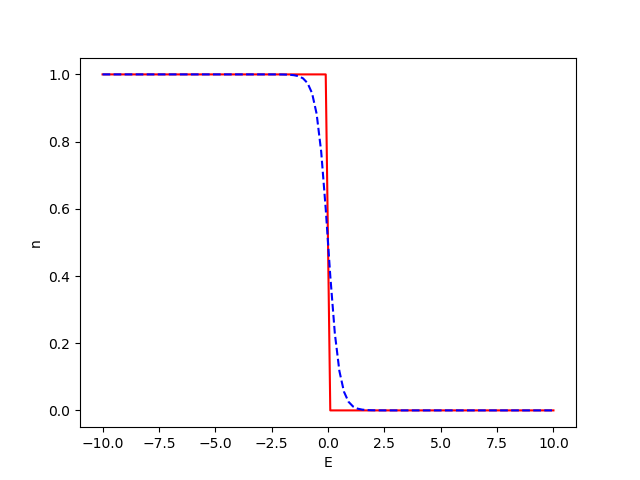

In [12]:
Energy_arr = np.linspace(-10.0, 10.0, 100, endpoint=True)
Chemical_Potential = 0.0

fig = plt.figure()
Temperatur = 0.0
plt.plot(Energy_arr, FermiDirac(Energy_arr), 'r-')
Temperatur = 0.25
plt.plot(Energy_arr, FermiDirac(Energy_arr), 'b--')
plt.ylabel('n')
plt.xlabel('E')

plt.show()

### Correlators

\begin{equation}
X_{\alpha \sigma , \beta \sigma'} \left(\vectr{k}\right) = \EW{\cOP{c}_{\vectr{k},\alpha,\sigma}\aOP{c}_{\vectr{k},\beta,\sigma'}}_{\mathrm{eff}} = \sum_{l} 
\left[ \boldsymbol{\xi}^{*}_{l}\left(\vectr{k}\right) \right]_{\alpha \sigma}
\left[ \boldsymbol{\xi}_{l}\left(\vectr{k}\right) \right]_{\beta \sigma'}
f_{\mathrm{FD}}\left(E_{l}\left(\vectr{k}\right)\right)
\end{equation}

In [13]:
def X(a,b, eigen_vectors, eigen_energies):
    sum = 0.0 + 0.0j
    for idevec, evec in enumerate(eigen_vectors):
        sum += np.conj(evec[a])*evec[b]*FermiDirac(eigen_energies[idevec])
    return sum

### Functional

\begin{equation}
\begin{split}
\Phi\left(\varrho_0, m, \theta \right)
%
&=\frac{U}{N_{\mathrm{UC}}} \left( 
\sum_{\vectr{k}} X_{\uparrow,\uparrow} \left(\vectr{k}\right)
\sum_{\vectr{k}'} X_{\downarrow,\downarrow} \left(\vectr{k}'\right)
-\sum_{\vectr{k}} X_{\uparrow,\downarrow} \left(\vectr{k}\right)
\sum_{\vectr{k}'} X_{\downarrow,\uparrow} \left(\vectr{k}'\right)\right)\\
%
&- \frac{U}{2} \varrho^{\phantom{\dagger}}_{0} \sum_{\vectr{k}} \left[ X_{\uparrow,\uparrow} \left(\vectr{k}\right) + X_{\downarrow,\downarrow} \left(\vectr{k}\right)\right]\\
%
&+\frac{Um}{2} \sin{(\theta)} \sum_{\vectr{k}}
\left[ X_{\uparrow,\downarrow} \left(\vectr{k}\right) + X_{\downarrow,\uparrow} \left(\vectr{k}\right) \right]\\
%
&+\frac{Um}{2} \cos{(\theta)} \sum_{\vectr{k}}
\left[ X_{\uparrow,\uparrow} \left(\vectr{k}\right) - X_{\downarrow,\downarrow} \left(\vectr{k}\right)\right]\\
%
&- \frac{1}{\beta} \sum_{\vectr{k}} \sum_{l=1}^{2} \ln{\left( 1 + \exp\left( -\beta \left(E_l\left(\vectr{k}\right) - \mu\right) \right) \right)}
\end{split}
\end{equation}

### Free Energy Part

\begin{equation}
F(E_l(\vectr{k})) = - \frac{1}{\beta} \ln{\left( 1 + \exp\left( -\beta \left(E_l\left(\vectr{k}\right) - \mu\right) \right) \right)}
\end{equation}

In [126]:
def free_energy(eigen_energy, Temperatur, Chemical_Potential):
    if Temperatur == 0.0:
        if (eigen_energy - Chemical_Potential) < 0.0:
            return (eigen_energy - Chemical_Potential)
        else:
            return 0.0
    elif Temperatur > 0.0:
        print("Error. T>0.")
        sys.exit('Bad value, T>0.')
        return -Temperatur*np.log(1.0 + np.exp(-(1.0/Temperatur)*(eigen_energy - Chemical_Potential)))

    sys.exit('Bad value, T<0.')

In [151]:
def Func_UC_1S(n,m,theta,qx,qy):
    global Hubbard_U
    global number_of_steps
    global Chemical_Potential
    global kx_grid
    global ky_grid
    
    Temperatur = 0.0

    sum = 0.0 + 0.0j
    sum_00 = 0.0 + 0.0j
    sum_01 = 0.0 + 0.0j
    sum_10 = 0.0 + 0.0j
    sum_11 = 0.0 + 0.0j
    sum_free_energy = 0.0
    
    Band_1, Band_1_evec, Band_2, Band_2_evec = Set_Spectrum_Bands_UC_1S_evecs(np.array([qx,qy]),n,m,theta)
    
    intw_arr_1 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_1)
    intw_arr_2 = GZ_Integration_Weigths_2D_T_zero(Chemical_Potential, Band_2)

    sum_kx_grid = np.delete(kx_grid,0,0)
    sum_ky_grid = np.delete(ky_grid,0,0)

    for ikx, kx in enumerate(sum_kx_grid):
        for iky, ky in enumerate(sum_ky_grid):
            sum_00 += np.conj(Band_1_evec[iky][ikx][0])*Band_1_evec[iky][ikx][0]*intw_arr_1[iky][ikx]
            sum_00 += np.conj(Band_2_evec[iky][ikx][0])*Band_2_evec[iky][ikx][0]*intw_arr_2[iky][ikx]
            
            sum_01 += np.conj(Band_1_evec[iky][ikx][0])*Band_1_evec[iky][ikx][1]*intw_arr_1[iky][ikx]
            sum_01 += np.conj(Band_2_evec[iky][ikx][0])*Band_2_evec[iky][ikx][1]*intw_arr_2[iky][ikx]
            
            sum_10 += np.conj(Band_1_evec[iky][ikx][1])*Band_1_evec[iky][ikx][0]*intw_arr_1[iky][ikx]
            sum_10 += np.conj(Band_2_evec[iky][ikx][1])*Band_2_evec[iky][ikx][0]*intw_arr_2[iky][ikx]
            
            sum_11 += np.conj(Band_1_evec[iky][ikx][1])*Band_1_evec[iky][ikx][1]*intw_arr_1[iky][ikx]
            sum_11 += np.conj(Band_2_evec[iky][ikx][1])*Band_2_evec[iky][ikx][1]*intw_arr_2[iky][ikx]
            
            sum_free_energy += free_energy(Band_1[iky][ikx], Temperatur, Chemical_Potential)
            sum_free_energy += free_energy(Band_2[iky][ikx], Temperatur, Chemical_Potential)

    sum = - 0.5*Hubbard_U*n*(sum_00+sum_11)\
        - (Hubbard_U*sum_01*sum_10)\
        + (Hubbard_U*sum_00*sum_11)\
        + sum_free_energy/(number_of_steps*number_of_steps)\
        + 0.5*Hubbard_U*m*np.sin(theta)*(sum_01+sum_10)\
        + 0.5*Hubbard_U*m*np.cos(theta)*(sum_00-sum_11)

    if np.iscomplex(sum):
        print("COMPLEX:")
        print(sum)
    
    return(np.real(sum))

In [179]:
Chemical_Potential = 2.0
Hubbard_U = 10.0

n_steps = np.linspace(0.0, 2.0, 20, endpoint=True)
m_steps = np.linspace(0.0, 1.0, 10, endpoint=True)

functional_mesh = np.zeros(shape=(10,20))

f = FloatProgress(min=0, max=20)
display(f)

for idn, n in enumerate(n_steps):
    for idm, m in enumerate(m_steps):
        functional_mesh[idm][idn] = Func_UC_1S(n,m,np.pi,np.pi,np.pi)
    f.value += 1

FloatProgress(value=0.0, max=20.0)

<IPython.core.display.Javascript object>


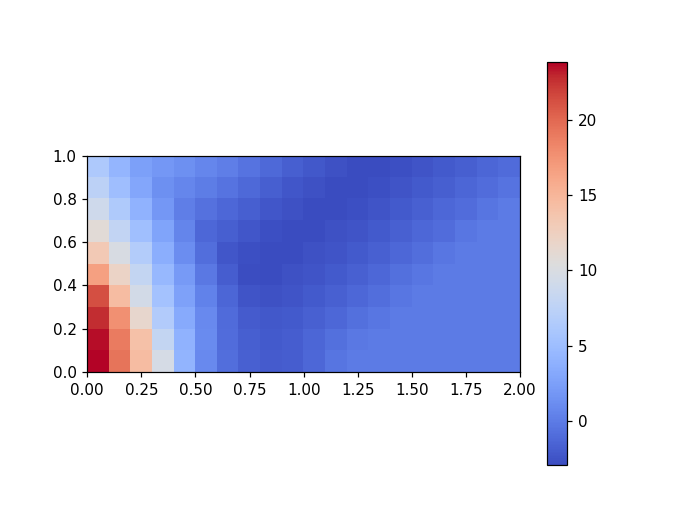

In [180]:
fig_functional_map = plt.figure()
im = plt.imshow(functional_mesh, extent=(0.0,2.0,0.0,1.0), origin='lower', cmap=cm.coolwarm) # drawing the function
#plt.xticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
#plt.yticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
# adding the Contour lines with labels
#cset = plt.contour(kx, ky, Band_1,np.arange(-4,4.0,1.0),linewidths=2,cmap=cm.Set2)
#plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#plt.colorbar(im) # adding the colobar on the right
plt.colorbar() # adding the colobar on the right
#plt.xticks([1,2])
# latex fashion title
plt.show()

<IPython.core.display.Javascript object>


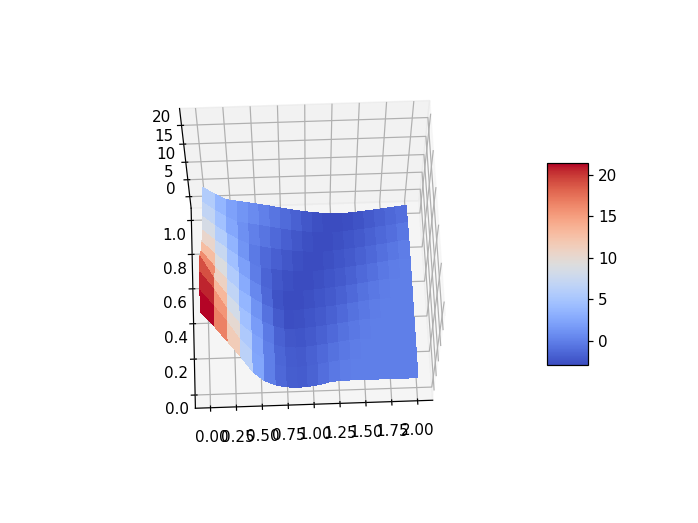

In [181]:
ngrid, mgrid = np.meshgrid(n_steps, m_steps)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(ngrid, mgrid, functional_mesh, rstride=1, cstride=1, 
                      cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1500.0, -750.0)
#ax.set_ylim(-1.0, 1.0)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Wrap für m Einschränkung

In [219]:
def MinFunc_Wrap_UC_1S(x):
    n= x[0]
    #m=x[1]
    m = x[1]*(1.0-np.fabs(1-x[0]))
    #theta = x[2]
    theta = 0.5*np.pi
    #qx = x[2]
    qx = np.pi
    #qy = x[3]
    qy = np.pi
    
    return Func_UC_1S(n,m,theta,qx,qy)

In [191]:
Chemical_Potential = 0.0
Hubbard_U = 10.0

n_steps = np.linspace(0.0, 2.0, 20, endpoint=True)
m_steps = np.linspace(0.0, 1.0, 10, endpoint=True)

functional_mesh = np.zeros(shape=(10,20))

f = FloatProgress(min=0, max=20)
display(f)

for idn, n in enumerate(n_steps):
    for idm, m in enumerate(m_steps):
        functional_mesh[idm][idn] = MinFunc_Wrap_UC_1S(np.array([n,m]))
    f.value += 1

FloatProgress(value=0.0, max=20.0)

<IPython.core.display.Javascript object>


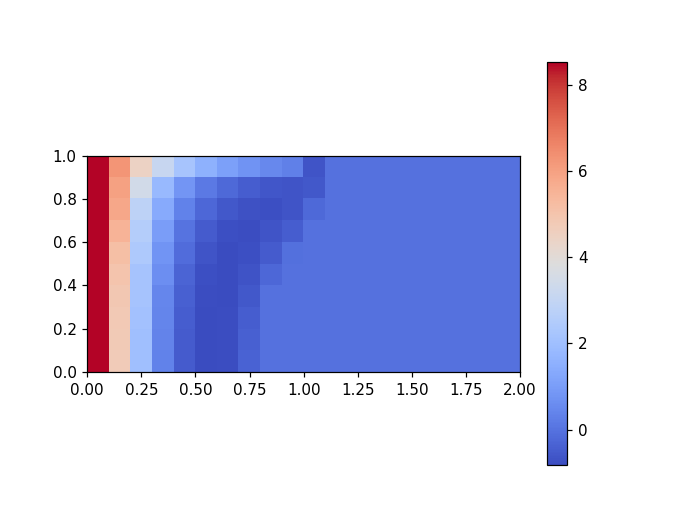

In [192]:
fig_functional_map = plt.figure()
im = plt.imshow(functional_mesh, extent=(0.0,2.0,0.0,1.0), origin='lower', cmap=cm.coolwarm) # drawing the function
#plt.xticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
#plt.yticks([-np.pi,-0.5*np.pi,0.0,0.5*np.pi,np.pi],[r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
# adding the Contour lines with labels
#cset = plt.contour(kx, ky, Band_1,np.arange(-4,4.0,1.0),linewidths=2,cmap=cm.Set2)
#plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
#plt.colorbar(im) # adding the colobar on the right
plt.colorbar() # adding the colobar on the right
#plt.xticks([1,2])
# latex fashion title
plt.show()

<IPython.core.display.Javascript object>


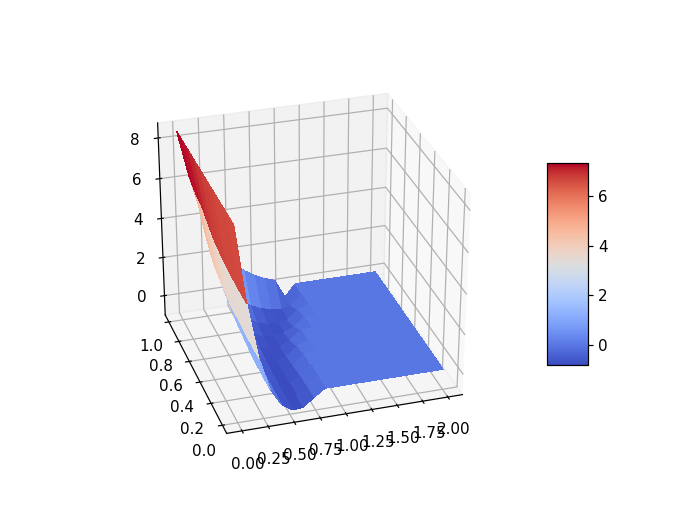

In [193]:
ngrid, mgrid = np.meshgrid(n_steps, m_steps)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(ngrid, mgrid, functional_mesh, rstride=1, cstride=1, 
                      cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1500.0, -750.0)
#ax.set_ylim(-1.0, 1.0)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### The Minimization

In [194]:
Temperatur = 0.0
Chemical_Potential = 1.0
Hubbard_U = 10.0

In [220]:
#bounds = [(0,2), (0.0, 1.0), (0.0,np.pi), (0.0,np.pi)]
bounds = [(0,2), (0.0, 1.0)]

In [ ]:
%%timeit -n 1 -r 1
result = shgo(MinFunc_Wrap_UC_1S, bounds, n=100, iters=5, sampling_method='sobol')
print(result.x,result.fun)

In [ ]:
%%timeit -n 1 -r 1
result = shgo(MinFunc_Wrap_UC_1S, bounds, iters=4, options={'disp': True, 'maxtime': 10})
print(result.x,result.fun)

In [ ]:
%%timeit -n 1 -r 1
init_arr = np.array([[1.0,1.0,0.5*np.pi,np.pi,np.pi],\
                     [1.0,0.5,0.5*np.pi,np.pi,np.pi],\
                     [1.0,1.0,0.5*np.pi,0.0,np.pi],\
                     [1.0,1.0,0.5*np.pi,np.pi,0.0],\
                     [1.0,1.0,0.0,0.0,0.0]])
result = differential_evolution(MinFunc_Wrap_UC_1S,\
                                bounds,\
                                init=init_arr,\
                                disp=True,\
                                maxiter=10,\
                                updating='deferred',\
                                workers=-1)
print(result.x,result.fun)

In [ ]:
%%timeit -n 1 -r 1
result = dual_annealing(MinFunc_Wrap_UC_1S, bounds, maxiter=500)
print(result.x,result.fun)

In [174]:
chem_pot_number_of_steps = 50
chem_pot_arr = np.linspace(-3.8, 14.0, chem_pot_number_of_steps, endpoint=True)

n_arr = np.zeros(chem_pot_number_of_steps)
m_arr = np.zeros(chem_pot_number_of_steps)
m_res_arr = np.zeros(chem_pot_number_of_steps)
theta_arr = np.zeros(chem_pot_number_of_steps)
qx_arr = np.zeros(chem_pot_number_of_steps)
qy_arr = np.zeros(chem_pot_number_of_steps)
fct_arr = np.zeros(chem_pot_number_of_steps)

<IPython.core.display.Javascript object>


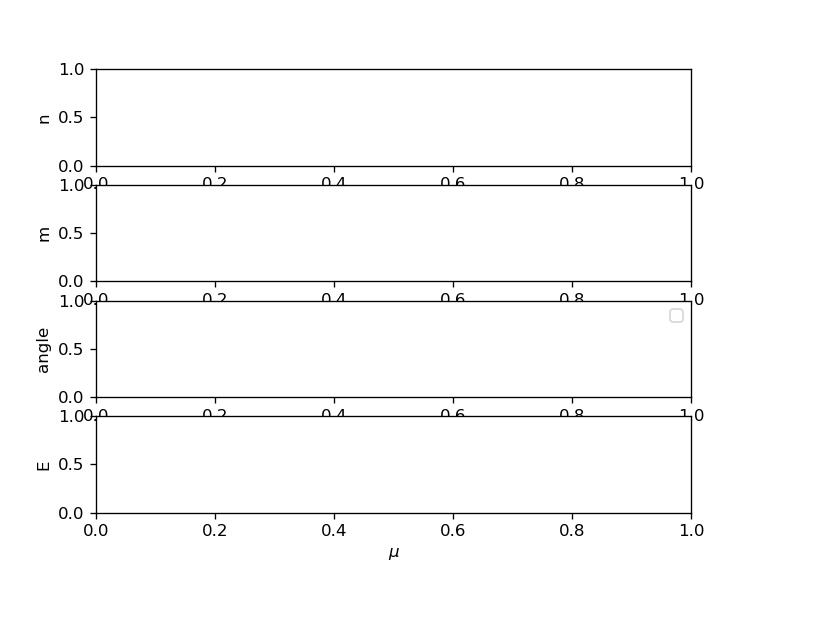

No handles with labels found to put in legend.


FloatProgress(value=0.0, max=50.0)

ValueError: The population supplied needs to have shape (M, len(x)), where M > 4.

Process ForkPoolWorker-120:
Process ForkPoolWorker-117:
Process ForkPoolWorker-119:
Traceback (most recent call last):
Process ForkPoolWorker-118:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File 

In [202]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, dpi=120)

ax1.set_ylabel('n')
ax1.set_xlabel('$\mu$')
ax2.set_ylabel('m')
ax2.set_xlabel('$\mu$')
ax3.set_ylabel('angle')
ax3.set_xlabel('$\mu$')
ax3.legend(loc='upper right')
ax4.set_ylabel('E')
ax4.set_xlabel('$\mu$')

chempotbar = FloatProgress(min=0, max=chem_pot_number_of_steps)
display(chempotbar)

#minimizer_kwargs = {"method":"L-BFGS-B"}
#x0 = [0.0, 0.0, 0.0, 0.0]
init_arr = np.array([[0.05,0.01,0.5*np.pi,np.pi,np.pi],\
                     [0.05,0.005,0.5*np.pi,np.pi,np.pi],\
                     [0.05,0.01,0.5*np.pi,0.0,np.pi],\
                     [0.05,0.01,0.5*np.pi,np.pi,0.0],\
                     [0.05,0.01,0.0,0.0,0.0]])
    
for idchem_pot, chem_pot in enumerate(chem_pot_arr):
    Chemical_Potential = chem_pot
        
    #result = shgo(MinFunc_Wrap, bounds)
    #result = shgo(MinFunc_Wrap_UC_1S, bounds, iters=3)
    #result = dual_annealing(MinFunc_Wrap, bounds, maxiter=200)
    #result = differential_evolution(MinFunc_Wrap_UC_1S, bounds, maxiter=1000, updating='deferred', workers=-1)
    result = differential_evolution(MinFunc_Wrap_UC_1S,\
                                    bounds,\
                                    init=init_arr,\
                                    polish=False,\
                                    disp=False,\
                                    maxiter=100,\
                                    updating='deferred',\
                                    workers=-1)
    
    init_arr = np.array([[result.x[0],result.x[1],0.5*np.pi,np.pi,np.pi],\
                         [result.x[0],0.5*result.x[1],0.5*np.pi,np.pi,np.pi],\
                         [result.x[0],result.x[1],0.5*np.pi,0.0,np.pi],\
                         [result.x[0],result.x[1],0.5*np.pi,np.pi,0.0],\
                         [result.x[0],result.x[1],0.0,0.0,0.0],\
                         [result.x[0],result.x[1],result.x[2],result.x[3],result.x[4]],
                         [0.05,0.01,0.5*np.pi,np.pi,np.pi],\
                         [0.05,0.005,0.5*np.pi,np.pi,np.pi],\
                         [0.05,0.01,0.5*np.pi,0.0,np.pi],\
                         [0.05,0.01,0.5*np.pi,np.pi,0.0],\
                         [0.05,0.01,0.0,0.0,0.0],\
                         [1.0,1.0,0.5*np.pi,np.pi,np.pi],\
                         [1.0,0.5,0.5*np.pi,np.pi,np.pi],\
                         [1.0,1.0,0.5*np.pi,0.0,np.pi],\
                         [1.0,1.0,0.5*np.pi,np.pi,0.0],\
                         [1.0,1.0,0.0,0.0,0.0],\
                         [2.0,1.0,0.5*np.pi,np.pi,np.pi],\
                         [2.0,0.5,0.5*np.pi,np.pi,np.pi],\
                         [2.0,1.0,0.5*np.pi,0.0,np.pi],\
                         [2.0,1.0,0.5*np.pi,np.pi,0.0],\
                         [2.0,1.0,0.0,0.0,0.0]])

    n_arr[idchem_pot] = result.x[0]
    m_arr[idchem_pot] = result.x[1]
    m_res_arr[idchem_pot] = result.x[1]*(1.0-np.fabs(1-result.x[0]))
    theta_arr[idchem_pot] = result.x[2]
    qx_arr[idchem_pot] = result.x[3]
    qy_arr[idchem_pot] = result.x[4]
    fct_arr[idchem_pot] = result.fun
    chempotbar.value += 1
    
    ax1.plot(chem_pot_arr, n_arr, 'go', label='n')
    ax2.plot(chem_pot_arr, m_arr, 'b*', label='m')
    ax2.plot(chem_pot_arr, m_res_arr, 'r-', label='m')
    ax3.plot(chem_pot_arr, theta_arr, 'r*', label='theta')
    ax3.plot(chem_pot_arr, qx_arr, 'bo', label='qx')
    ax3.plot(chem_pot_arr, qy_arr, 'g.', label='qx')
    ax4.plot(chem_pot_arr, fct_arr, 'r*', label='Free Energy')
    display(fig)
    clear_output(wait = True)
    plt.pause(0.5)

<IPython.core.display.Javascript object>


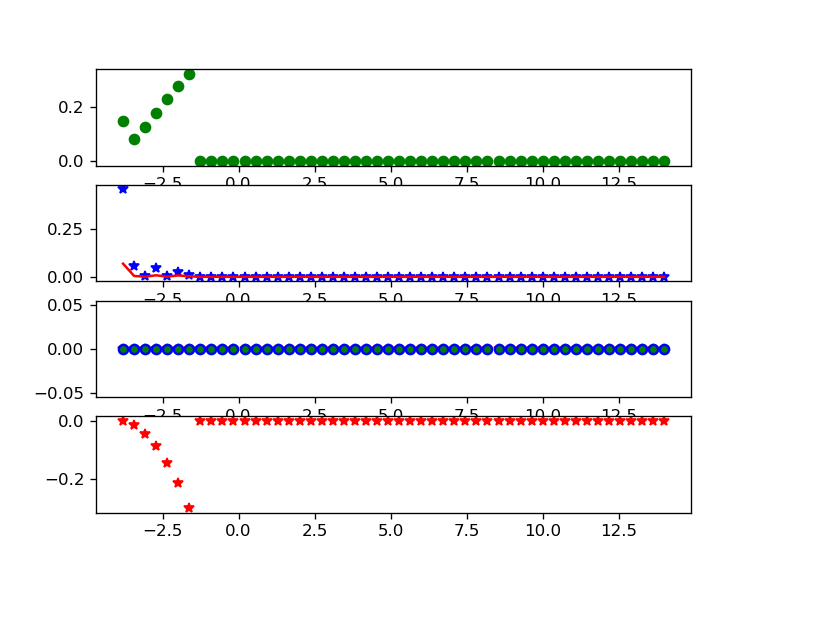

No handles with labels found to put in legend.


FloatProgress(value=0.0, max=50.0)

Process ForkPoolWorker-556:
Process ForkPoolWorker-554:
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-553:
Traceback (most recent call last):
Process ForkPoolWorker-555:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/chris/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/chris/anaconda3/lib/python3.7/mu

KeyboardInterrupt: 

  File "<ipython-input-52-da05dd9dfec5>", line 13, in Hamiltonian_UC_1S
    A[1][1] = Hopping_UC_1S(k+q)
  File "<ipython-input-51-bda01c4829aa>", line 6, in Hopping_UC_1S
    hopping_amplitude += t*np.exp((Tvec[0]*k[0]+Tvec[1]*k[1])*1.0j)
  File "<ipython-input-51-bda01c4829aa>", line 6, in Hopping_UC_1S
    hopping_amplitude += t*np.exp((Tvec[0]*k[0]+Tvec[1]*k[1])*1.0j)
  File "<ipython-input-219-efb9134b55a6>", line 12, in MinFunc_Wrap_UC_1S
    return Func_UC_1S(n,m,theta,qx,qy)
  File "<ipython-input-151-7c9ca107c48d>", line 17, in Func_UC_1S
    Band_1, Band_1_evec, Band_2, Band_2_evec = Set_Spectrum_Bands_UC_1S_evecs(np.array([qx,qy]),n,m,theta)
KeyboardInterrupt
  File "<ipython-input-178-0cc37587a0d7>", line 43, in Set_Spectrum_Bands_UC_1S_evecs
    w, v = la.eigh(Hamiltonian_UC_1S(np.array([kx,ky]),q,n,m,theta))
KeyboardInterrupt
  File "<ipython-input-52-da05dd9dfec5>", line 13, in Hamiltonian_UC_1S
    A[1][1] = Hopping_UC_1S(k+q)
  File "<ipython-input-51-bda01c4829aa>", l

In [224]:
Hubbard_U = 10.0

chem_pot_number_of_steps = 50
chem_pot_arr = np.linspace(-3.8, 14.0, chem_pot_number_of_steps, endpoint=True)

n_arr = np.zeros(chem_pot_number_of_steps)
m_arr = np.zeros(chem_pot_number_of_steps)
m_res_arr = np.zeros(chem_pot_number_of_steps)
theta_arr = np.zeros(chem_pot_number_of_steps)
qx_arr = np.zeros(chem_pot_number_of_steps)
qy_arr = np.zeros(chem_pot_number_of_steps)
fct_arr = np.zeros(chem_pot_number_of_steps)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, dpi=120)

ax1.set_ylabel('n')
ax1.set_xlabel('$\mu$')
ax2.set_ylabel('m')
ax2.set_xlabel('$\mu$')
ax3.set_ylabel('angle')
ax3.set_xlabel('$\mu$')
ax3.legend(loc='upper right')
ax4.set_ylabel('E')
ax4.set_xlabel('$\mu$')

plt.ion()

fig.show()
fig.canvas.draw()

chempotbar = FloatProgress(min=0, max=chem_pot_number_of_steps)
display(chempotbar)

#minimizer_kwargs = {"method":"L-BFGS-B"}
#x0 = [0.0, 0.0, 0.0, 0.0]
init_arr = np.array([[0.05,0.01,np.pi,np.pi],\
                     [0.05,0.005,np.pi,np.pi],\
                     [0.05,0.01,0.0,np.pi],\
                     [0.05,0.01,np.pi,0.0],\
                     [0.05,0.01,0.0,0.0]])
    
for idchem_pot, chem_pot in enumerate(chem_pot_arr):
    Chemical_Potential = chem_pot
        
    #result = shgo(MinFunc_Wrap, bounds)
    #result = shgo(MinFunc_Wrap_UC_1S, bounds, iters=3)
    #result = dual_annealing(MinFunc_Wrap, bounds, maxiter=200)
    #result = differential_evolution(MinFunc_Wrap_UC_1S, bounds, maxiter=1000, updating='deferred', workers=-1)
    result = differential_evolution(MinFunc_Wrap_UC_1S,\
                                    bounds,\
                                    #init=init_arr,\
                                    polish=False,\
                                    disp=False,\
                                    maxiter=1000,\
                                    updating='deferred',\
                                    workers=-1)
    
    init_arr = np.array([[result.x[0],result.x[1],np.pi,np.pi],\
                         [result.x[0],0.5*result.x[1],np.pi,np.pi],\
                         [result.x[0],result.x[1],0.0,np.pi],\
                         [result.x[0],result.x[1],np.pi,0.0],\
                         [result.x[0],result.x[1],0.0,0.0],\
                         #[result.x[0],result.x[1],result.x[2],result.x[3]],
                         [0.05,0.01,np.pi,np.pi],\
                         [0.05,0.005,np.pi,np.pi],\
                         [0.05,0.01,0.0,np.pi],\
                         [0.05,0.01,np.pi,0.0],\
                         [0.05,0.01,0.0,0.0],\
                         [1.0,1.0,np.pi,np.pi],\
                         [1.0,0.5,np.pi,np.pi],\
                         [1.0,1.0,0.0,np.pi],\
                         [1.0,1.0,np.pi,0.0],\
                         [1.0,1.0,0.0,0.0],\
                         [2.0,1.0,np.pi,np.pi],\
                         [2.0,0.5,np.pi,np.pi],\
                         [2.0,1.0,0.0,np.pi],\
                         [2.0,1.0,np.pi,0.0],\
                         [2.0,1.0,0.0,0.0]])

    n_arr[idchem_pot] = result.x[0]
    m_arr[idchem_pot] = result.x[1]
    m_res_arr[idchem_pot] = result.x[1]*(1.0-np.fabs(1-result.x[0]))
    #qx_arr[idchem_pot] = result.x[2]
    #qy_arr[idchem_pot] = result.x[3]
    fct_arr[idchem_pot] = result.fun
    chempotbar.value += 1
    
    ax1.clear()
    ax1.plot(chem_pot_arr, n_arr, 'go', label='n')
    ax2.clear()
    ax2.plot(chem_pot_arr, m_arr, 'b*', label='m')
    ax2.plot(chem_pot_arr, m_res_arr, 'r-', label='m')
    ax3.clear()
    ax3.plot(chem_pot_arr, theta_arr, 'r*', label='theta')
    ax3.plot(chem_pot_arr, qx_arr, 'bo', label='qx')
    ax3.plot(chem_pot_arr, qy_arr, 'g.', label='qx')
    ax4.clear()
    ax4.plot(chem_pot_arr, fct_arr, 'r*', label='Free Energy')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


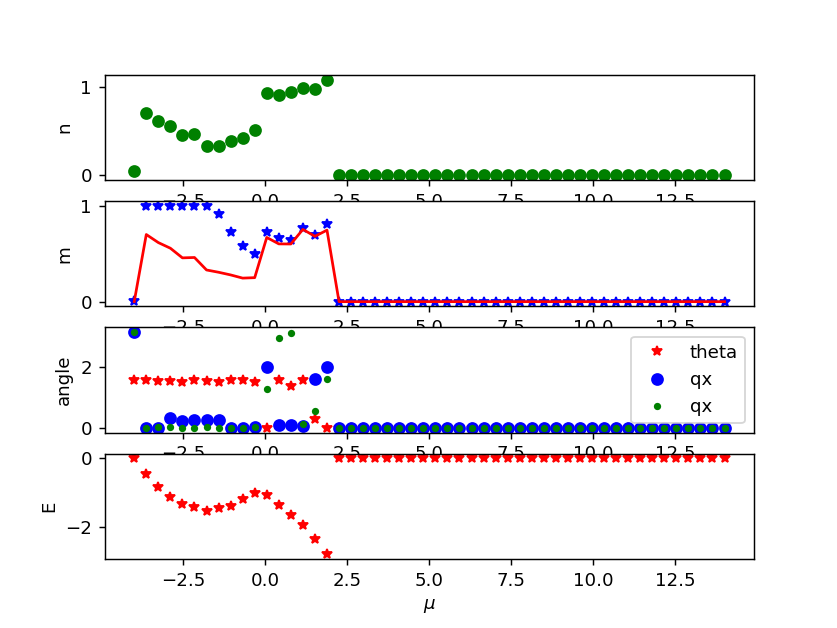

In [206]:
# Create Figure and Subplots
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8,20), dpi=120)
#fig.subplots_adjust(wspace=0)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, dpi=120)

# Plot
ax1.set_ylabel('n')
ax1.set_xlabel('$\mu$')
ax1.plot(chem_pot_arr, n_arr, 'go', label='n')

ax2.set_ylabel('m')
ax2.set_xlabel('$\mu$')
ax2.plot(chem_pot_arr, m_arr, 'b*', label='m')
ax2.plot(chem_pot_arr, m_res_arr, 'r-', label='m')

ax3.set_ylabel('angle')
ax3.set_xlabel('$\mu$')
ax3.plot(chem_pot_arr, theta_arr, 'r*', label='theta')
ax3.plot(chem_pot_arr, qx_arr, 'bo', label='qx')
ax3.plot(chem_pot_arr, qy_arr, 'g.', label='qx')
# Modify legend
ax3.legend(loc='upper right')
#plt.legend([sine[0], cosine[0], sine_2[0], cosine_2[0]],   # plot items
#           ['sine curve', 'cosine curve', 'sine curve 2', 'cosine curve 2'],  
#           frameon=True,                                   # legend border
#           framealpha=1,                                   # transparency of border
#           ncol=2,                                         # num columns
#           shadow=True,                                    # shadow on
#           borderpad=1,                                    # thickness of border
#           title='Sines and Cosines')                      # title

ax4.set_ylabel('E')
ax4.set_xlabel('$\mu$')
ax4.plot(chem_pot_arr, fct_arr, 'r*', label='Free Energy')

#ax1.set_title('Scatterplot Greendots')
#ax2.set_title('Scatterplot Bluestars')

plt.show()

<IPython.core.display.Javascript object>


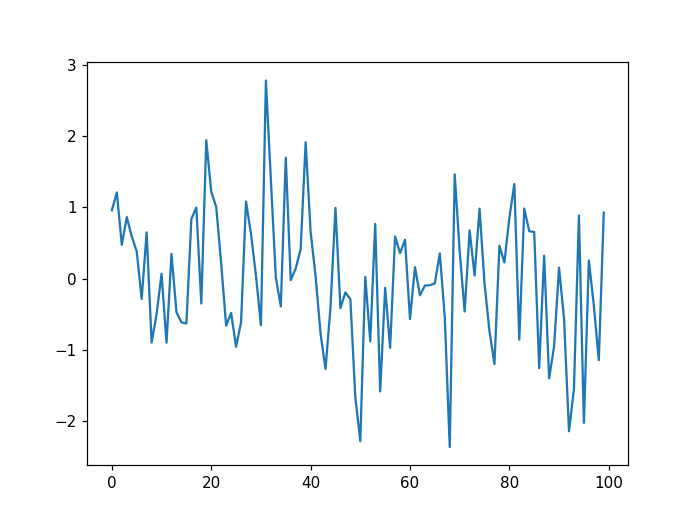

In [213]:
#https://stackoverflow.com/questions/39658717/plot-dynamically-changing-graph-using-matplotlib-in-jupyter-notebook
m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[i,:])
    fig.canvas.draw()